### Preprocessing e impostazione della rete

#### Inserimento dei pesi e rimozione colonna "type"

In [66]:
import pandas as pd

# Caricare i file CSV
characters_df = pd.read_csv('Data/characters.csv')  # Carica il file CSV dei personaggi
relations_df = pd.read_csv('Data/relations.csv')  # Carica il file CSV delle relazioni

# Parole chiave per le relazioni familiari
family_keywords = ['brother', 'sister', 'father', 'mother', 'son', 'daughter', 'cousin']

# Creiamo un dizionario per le biografie dei personaggi
character_bio = characters_df.set_index('id')['bio'].to_dict()

# Funzione per classificare le relazioni
def classify_relation(row):
    source_bio = character_bio.get(row['source'], "").lower()
    target_bio = character_bio.get(row['target'], "").lower()
    
    # Verifica se ci sono relazioni familiari
    if any(keyword in source_bio for keyword in family_keywords) or any(keyword in target_bio for keyword in family_keywords):
        return 'family'
    # Altri tipi di relazione
    elif row['type'] == '+':
        return 'friendship'  # Amicizia
    elif row['type'] == '-':
        return 'enmity'  # Nemici
    return 'neutral'  # Relazione neutrale

# Applicare la funzione di classificazione delle relazioni
relations_df['relation_detail'] = relations_df.apply(classify_relation, axis=1)

# Mappare i pesi per ogni tipo di relazione
weights = {
    'family': 4,
    'friendship': 2,
    'enmity': 3,
    'neutral': 0,
}
relations_df['weight'] = relations_df['relation_detail'].map(weights)

# Rimuovere la colonna "type"
relations_df = relations_df.drop(columns=['type'])

# Salvare il DataFrame aggiornato in un nuovo file CSV
#relations_df.to_csv('Data/relations_with_details.csv', index=False)

# Visualizzare i primi risultati
print(relations_df.head())

   source  target relation_detail  weight
0       0       1          family       4
1       0      25          family       4
2       0      45          family       4
3       1       0          family       4
4       1      11          family       4


#### Unione dei dataset

Vedere se è utile avere uno unico (alcuni dati si ripetono)

In [67]:
import pandas as pd

# Carica i file CSV
relations_df = pd.read_csv('Data/relations_with_details.csv')  # Relazioni con dettagli
characters_df = pd.read_csv('Data/characters.csv')  # Personaggi

# Unire le informazioni sui personaggi per il 'source' (personaggio di partenza)
relations_df = relations_df.merge(characters_df[['id', 'name', 'bio']], how='left', left_on='source', right_on='id')
relations_df = relations_df.rename(columns={'name': 'source_name', 'bio': 'source_bio'})

# Unire le informazioni sui personaggi per il 'target' (personaggio di arrivo)
relations_df = relations_df.merge(characters_df[['id', 'name', 'bio']], how='left', left_on='target', right_on='id')
relations_df = relations_df.rename(columns={'name': 'target_name', 'bio': 'target_bio'})

# Rimuovere le colonne temporanee 'id' usate per il merge
relations_df = relations_df.drop(columns=['id_x', 'id_y'])

# Salvare il DataFrame combinato in un nuovo file CSV
#relations_df.to_csv('Data/combined_relations.csv', index=False)

# Visualizzare i primi risultati
print(relations_df.head())

   source  target relation_detail  weight             source_name  \
0       0       1          family       4  Regulus Arcturus Black   
1       0      25          family       4  Regulus Arcturus Black   
2       0      45          family       4  Regulus Arcturus Black   
3       1       0          family       4            Sirius Black   
4       1      11          family       4            Sirius Black   

                                          source_bio             target_name  \
0  Brother of Sirius. Used to be a Death Eater bu...            Sirius Black   
1  Brother of Sirius. Used to be a Death Eater bu...     Bellatrix Lestrange   
2  Brother of Sirius. Used to be a Death Eater bu...          Lord Voldemort   
3  Best friend of James Potter and godfather of H...  Regulus Arcturus Black   
4  Best friend of James Potter and godfather of H...        Albus Dumbledore   

                                          target_bio  
0  Best friend of James Potter and godfather of H

### Nodes-edges extraction

In [68]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
from networkx.algorithms import community
import community

In [69]:
# set the nodes
with open('Data/characters.csv', 'r') as nodecsv:   
    # read the csv               
    nodereader = csv.reader(nodecsv) 
    # the mapping dictionary contains node number to character name pairs that will be used as labels later on while drawing the graph
    mapping = {}
    nodes = []
    # get the nodes
    for n in nodereader:
        nodes.append(n[0])
        mapping[n[0]] = n[1]
nodes = nodes[1:]
# delete the first id key-value pair
del mapping['id']
print('All nodes : ', nodes)
print('Character mapping : ', mapping)

All nodes :  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64']
Character mapping :  {'0': 'Regulus Arcturus Black', '1': 'Sirius Black', '2': 'Lavender Brown', '3': 'Cho Chang', '4': 'Vincent Crabbe Sr.', '5': 'Vincent Crabbe', '6': 'Bartemius "Barty" Crouch Sr.', '7': 'Bartemius "Barty" Crouch Jr.', '8': 'Fleur Delacour', '9': 'Cedric Diggory', '10': 'Alberforth Dumbledore', '11': 'Albus Dumbledore', '12': 'Dudley Dursley', '13': 'Petunia Dursley', '14': 'Vernon Dursley', '15': 'Argus Filch', '16': 'Seamus Finnigan', '17': 'Nicolas Flamel', '18': 'Cornelius Fudge', '19': 'Goyle Sr.', '20': 'Gregory Goyle', '21': 'Hermione Granger', '22': 'Rubeus Hagrid', '23':

In [70]:
# set the edges
# open the file
with open('Data/relations_with_details.csv', 'r') as edgecsv: 
    # read csv
    edgereader = csv.reader(edgecsv)
    # get the edges
    # edges = [tuple(e[:-1] + [1] if e[-1] == '+') for e in edgereader][1:]
    edges = []
    for e in edgereader:
        edges.append(tuple(e[:2] + e[3:]))
    edges = edges[1:]
# printing the edge pairs to the console
print('All edges : ', edges)

All edges :  [('0', '1', '4'), ('0', '25', '4'), ('0', '45', '4'), ('1', '0', '4'), ('1', '11', '4'), ('1', '21', '4'), ('1', '25', '4'), ('1', '31', '4'), ('1', '33', '4'), ('1', '34', '4'), ('1', '36', '4'), ('1', '37', '4'), ('1', '38', '4'), ('1', '39', '4'), ('1', '40', '4'), ('1', '41', '4'), ('1', '45', '4'), ('1', '47', '4'), ('1', '48', '4'), ('1', '50', '4'), ('1', '53', '4'), ('1', '54', '4'), ('1', '55', '4'), ('1', '58', '4'), ('2', '21', '3'), ('2', '28', '2'), ('2', '58', '2'), ('3', '9', '2'), ('3', '16', '2'), ('3', '21', '2'), ('3', '28', '2'), ('3', '39', '2'), ('3', '45', '3'), ('3', '58', '2'), ('4', '0', '4'), ('4', '5', '4'), ('4', '6', '4'), ('4', '25', '4'), ('4', '33', '4'), ('4', '38', '4'), ('4', '45', '4'), ('4', '47', '4'), ('5', '4', '4'), ('5', '49', '2'), ('5', '20', '2'), ('5', '21', '3'), ('5', '32', '2'), ('5', '39', '3'), ('5', '58', '3'), ('6', '4', '4'), ('6', '7', '4'), ('6', '23', '4'), ('6', '57', '4'), ('7', '6', '4'), ('7', '21', '4'), ('7', 

In [71]:
# find the relationship groups
e_3 = [(u, v) for (u, v, d) in edges if d == '4']
print('Family relatonships : ', e_3)

e_2 = [(u, v) for (u, v, d) in edges if d == '2']
print('Friendship relatonships : ', e_2)

e_0 = [(u, v) for (u, v, d) in edges if d == '0']
print('Neutral relatonships : ', e_0)

e_n3 = [(u, v) for (u, v, d) in edges if d == '3']
print('Enmity relatonships : ', e_n3)


Family relatonships :  [('0', '1'), ('0', '25'), ('0', '45'), ('1', '0'), ('1', '11'), ('1', '21'), ('1', '25'), ('1', '31'), ('1', '33'), ('1', '34'), ('1', '36'), ('1', '37'), ('1', '38'), ('1', '39'), ('1', '40'), ('1', '41'), ('1', '45'), ('1', '47'), ('1', '48'), ('1', '50'), ('1', '53'), ('1', '54'), ('1', '55'), ('1', '58'), ('4', '0'), ('4', '5'), ('4', '6'), ('4', '25'), ('4', '33'), ('4', '38'), ('4', '45'), ('4', '47'), ('5', '4'), ('6', '4'), ('6', '7'), ('6', '23'), ('6', '57'), ('7', '6'), ('7', '21'), ('7', '28'), ('7', '36'), ('7', '37'), ('7', '39'), ('7', '45'), ('7', '47'), ('7', '38'), ('8', '51'), ('8', '55'), ('8', '56'), ('10', '11'), ('10', '21'), ('10', '39'), ('10', '58'), ('10', '59'), ('11', '1'), ('11', '10'), ('11', '13'), ('11', '40'), ('11', '41'), ('11', '50'), ('11', '51'), ('11', '52'), ('11', '55'), ('11', '56'), ('11', '57'), ('12', '14'), ('12', '39'), ('12', '22'), ('13', '11'), ('13', '12'), ('13', '39'), ('13', '41'), ('14', '12'), ('14', '13'),

#### Graph construction

In [72]:
# construct the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

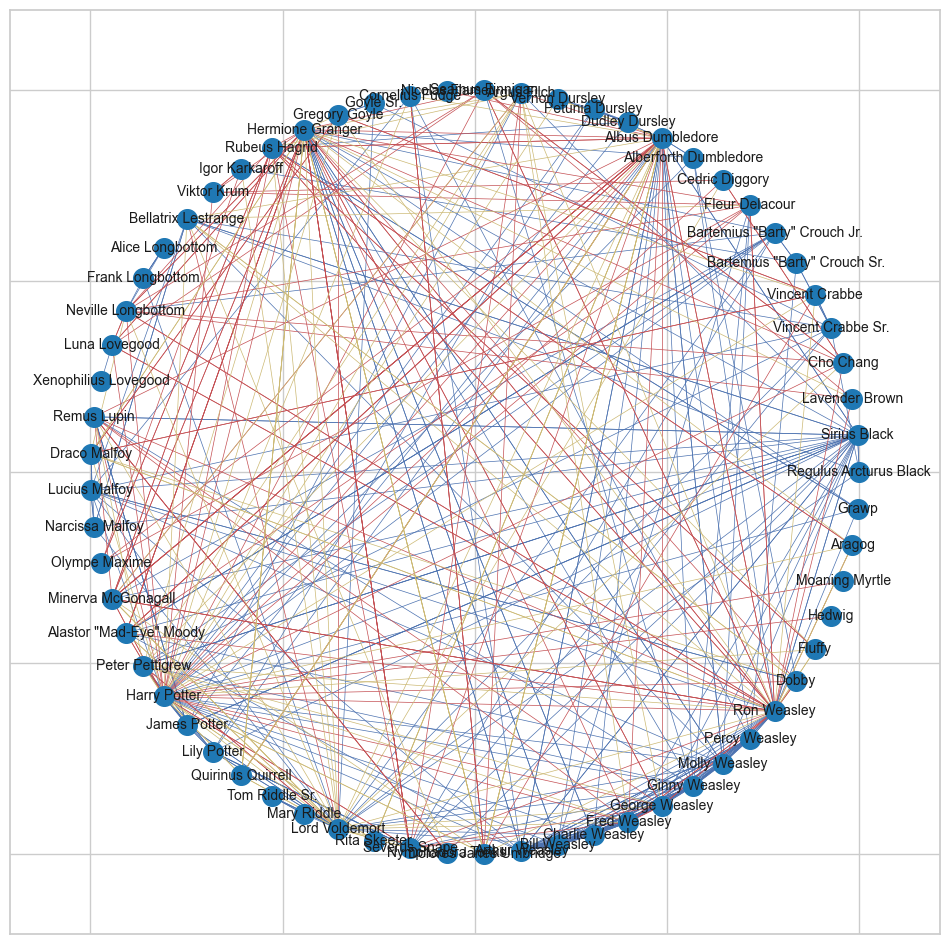

In [73]:
# draw the graph using the pyplot library
plt.figure(3,figsize=(12,12)) 
# draw the nodes
nx.draw_networkx_nodes(G, nx.circular_layout(G), node_size=200)
# draw the positive relationship edges in BLUE
nx.draw_networkx_edges(G, nx.circular_layout(G), edgelist=e_3, edge_color='b', width=0.5)
# draw the negative relationship edges in RED
nx.draw_networkx_edges(G, nx.circular_layout(G), edgelist=e_2, edge_color='r', width=0.5)
# draw the negative relationship edges in GREEN
nx.draw_networkx_edges(G, nx.circular_layout(G), edgelist=e_0, edge_color='g', width=0.5)
# draw the negative relationship edges in YELLOW
nx.draw_networkx_edges(G, nx.circular_layout(G), edgelist=e_n3, edge_color='y', width=0.5)
# add the character names from the mapping as labels
nx.draw_networkx_labels(G, nx.circular_layout(G), labels = mapping, font_size=10, font_family='sans-serif')
# display the plot
plt.show()

#### Spring layout

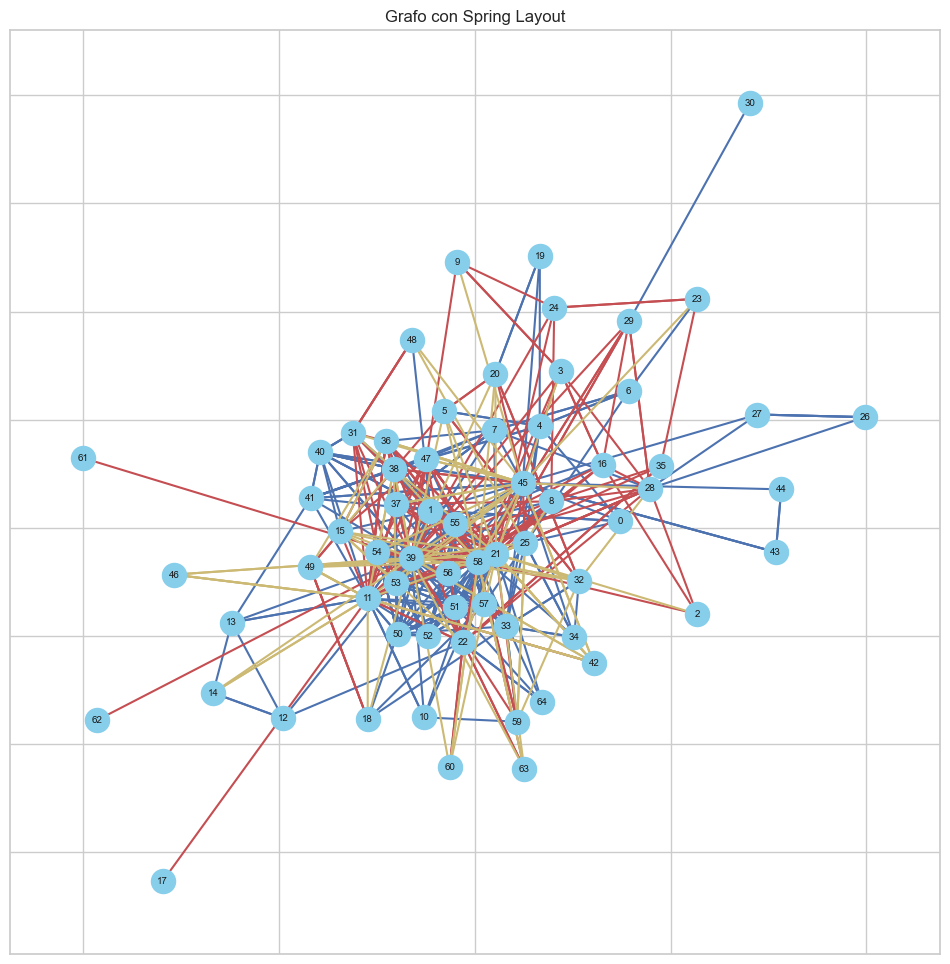

In [74]:
# Spring layout
pos = nx.spring_layout(G)

# Disegno del grafo
plt.figure(figsize=(12, 12))

# Disegno dei nodi
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')

# Disegno degli archi con colori differenti
nx.draw_networkx_edges(G, pos, edgelist=e_3, edge_color='b', width=1.5)
nx.draw_networkx_edges(G, pos, edgelist=e_2, edge_color='r', width=1.5)
nx.draw_networkx_edges(G, pos, edgelist=e_0, edge_color='g', width=1.5)
nx.draw_networkx_edges(G, pos, edgelist=e_n3, edge_color='y', width=1.5)

# Etichette dei nodi
nx.draw_networkx_labels(G, pos, font_size=7, font_family='sans-serif')

# Mostra il grafico
plt.title("Grafo con Spring Layout")
plt.show()

#### Weight distribution

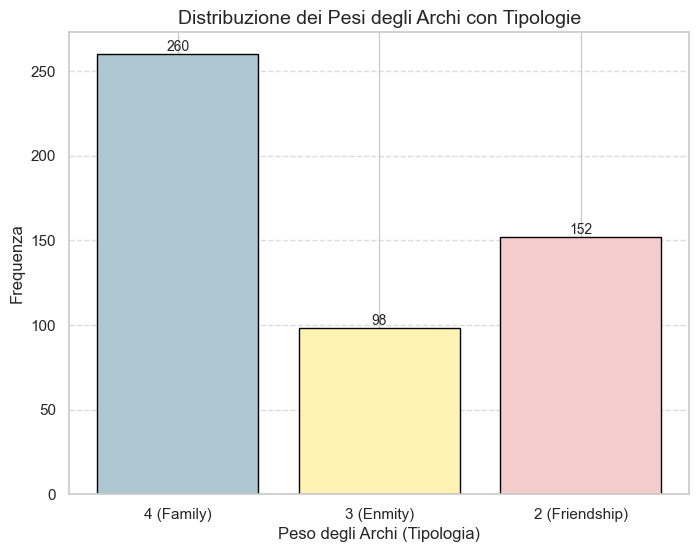

In [75]:
import matplotlib.pyplot as plt
from collections import Counter

# Estrazione dei pesi degli archi
weights = [w for _, _, w in edges]

# Calcolo della distribuzione dei pesi
weight_counts = Counter(weights)

# Preparazione dei dati per il grafico
weight_values = list(weight_counts.keys())
frequencies = list(weight_counts.values())

# Mapping dei colori per ogni peso
color_mapping = {
    '4': '#aec6cf',
    '2': '#f4cccc',
    '3': '#fff2b2'
}
label_mapping = {
    '4': 'Family',
    '2': 'Friendship',
    '3': 'Enmity'
}

# Creazione delle etichette combinate (es: "3 (Family)")
weight_labels = [f"{w} ({label_mapping[w]})" for w in weight_values]
bar_colors = [color_mapping[w] for w in weight_values]

# Creazione del grafico a colonne
plt.figure(figsize=(8, 6))
bars = plt.bar(weight_labels, frequencies, color=bar_colors, edgecolor='black')

# Aggiunta di etichette sopra le barre
for bar, freq in zip(bars, frequencies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, str(freq),
             ha='center', va='bottom', fontsize=10)

# Aggiunta di etichette e titolo
plt.xlabel("Peso degli Archi (Tipologia)", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)
plt.title("Distribuzione dei Pesi degli Archi con Tipologie", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostra il grafico
plt.show()

### Centrality

#### Degree centrality

In [76]:
# Calcolo della degree centrality
degree_centrality = nx.degree_centrality(G)

# Ordinare i nodi in base alla degree centrality (decrescente)
sorted_by_degree_centrality_desc = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Estrarre i 10 nodi con la maggiore degree centrality
top_10_nodes = sorted_by_degree_centrality_desc[:10]

# Estrarre i 10 nodi con la minore degree centrality
bottom_10_nodes = sorted_by_degree_centrality_desc[len(sorted_by_degree_centrality_desc)-10:]

# Visualizzare i 10 nodi con maggiore degree centrality (usando il nome)
print("Top 10 nodes with highest degree centrality:")
for node, centrality in top_10_nodes:
    node_name = mapping.get(str(node), "Unknown")  # Ottieni il nome dal dizionario
    print(f"Node {node_name} (ID {node}): {centrality:.4f}")

# Visualizzare i 10 nodi con minore degree centrality (usando il nome)
print("\nBottom 10 nodes with lowest degree centrality:")
for node, centrality in bottom_10_nodes:
    node_name = mapping.get(str(node), "Unknown")  # Ottieni il nome dal dizionario
    print(f"Node {node_name} (ID {node}): {centrality:.4f}")

Top 10 nodes with highest degree centrality:
Node Harry Potter (ID 39): 0.7500
Node Ron Weasley (ID 58): 0.5781
Node Hermione Granger (ID 21): 0.5625
Node Lord Voldemort (ID 45): 0.5625
Node Albus Dumbledore (ID 11): 0.5000
Node Sirius Black (ID 1): 0.3594
Node Ginny Weasley (ID 55): 0.2812
Node Fred Weasley (ID 53): 0.2656
Node George Weasley (ID 54): 0.2656
Node Molly Weasley (ID 56): 0.2656

Bottom 10 nodes with lowest degree centrality:
Node Goyle Sr. (ID 19): 0.0469
Node Frank Longbottom (ID 27): 0.0469
Node Alice Longbottom (ID 26): 0.0312
Node Tom Riddle Sr. (ID 43): 0.0312
Node Mary Riddle (ID 44): 0.0312
Node Rita Skeeter (ID 46): 0.0312
Node Nicolas Flamel (ID 17): 0.0156
Node Xenophilius Lovegood (ID 30): 0.0156
Node Hedwig (ID 61): 0.0156
Node Moaning Myrtle (ID 62): 0.0156


##### Plotting degree-centrality

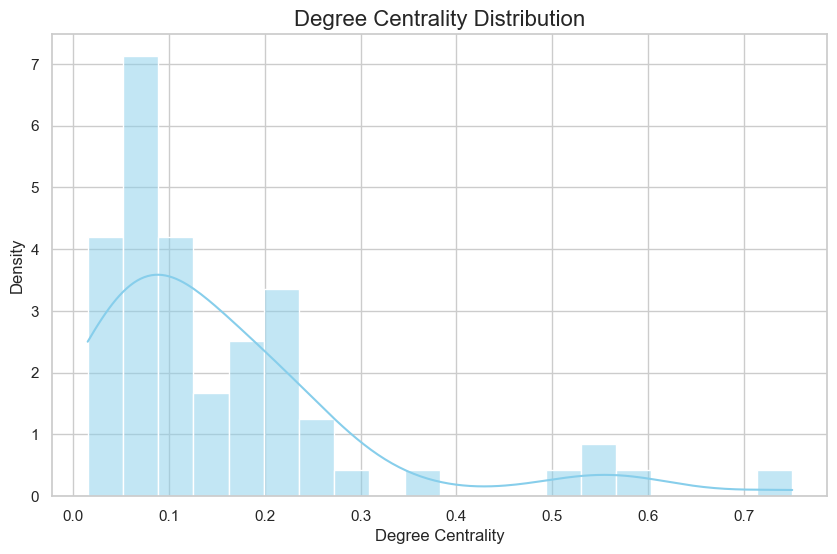

In [77]:
import seaborn as sns

# Convertire la degree centrality in una lista per il displot
degree_centrality_values = list(degree_centrality.values())

# Creare il displot della degree centrality
plt.figure(figsize=(10, 6))
sns.histplot(degree_centrality_values, kde=True, bins=20, color='skyblue', stat='density')
plt.title("Degree Centrality Distribution", fontsize=16)
plt.xlabel("Degree Centrality", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.show()

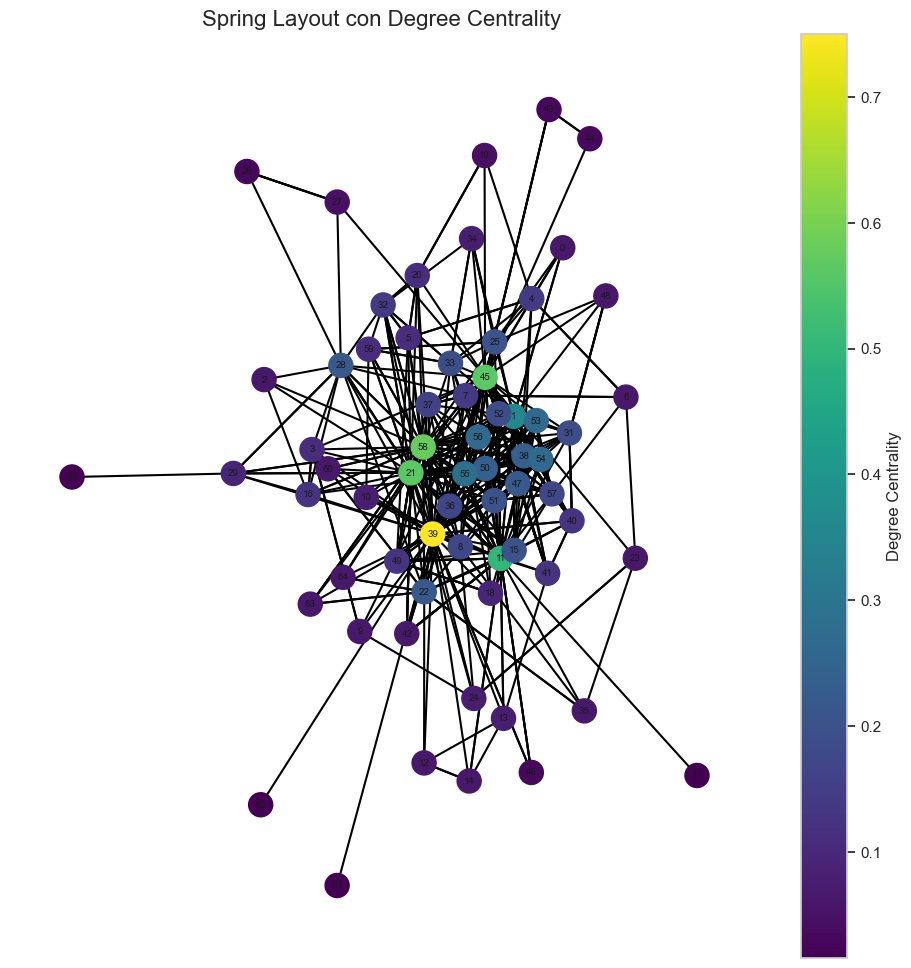

In [78]:
# Normalizzare i valori di centralità per mappare i colori (da 0 a 1)
centrality_values = list(degree_centrality.values())
max_centrality = max(centrality_values)
min_centrality = min(centrality_values)
normalized_centrality = [(centrality - min_centrality) / (max_centrality - min_centrality) for centrality in centrality_values]

# Creare una mappa di colori (colormap)
# Puoi scegliere altre colormap come 'coolwarm', 'plasma', 'inferno', etc.
colormap = plt.cm.viridis  # Colormap per colorare i nodi
node_colors = [colormap(value) for value in normalized_centrality]

# Spring layout (posizionamento dei nodi)
pos = nx.spring_layout(G, seed=42)

# Disegnare il grafo
plt.figure(figsize=(12, 12))
ax = plt.gca()  # Ottieni l'axes corrente

# Disegnare i nodi con colori basati sulla degree centrality
nodes = nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors, ax=ax)

# Disegnare gli archi con colori differenti per ciascun tipo
nx.draw_networkx_edges(G, pos, edgelist=e_3, edge_color='black', width=1.5, ax=ax)
nx.draw_networkx_edges(G, pos, edgelist=e_2, edge_color='black', width=1.5, ax=ax)
nx.draw_networkx_edges(G, pos, edgelist=e_0, edge_color='black', width=1.5, ax=ax)
nx.draw_networkx_edges(G, pos, edgelist=e_n3, edge_color='black', width=1.5, ax=ax)

# Etichette dei nodi
nx.draw_networkx_labels(G, pos, font_size=7, font_family='sans-serif', ax=ax)

# Aggiungere una barra dei colori per rappresentare la degree centrality
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=min_centrality, vmax=max_centrality))
sm.set_array([])  # Necessario per il corretto funzionamento
plt.colorbar(sm, ax=ax, label='Degree Centrality')

# Titolo e visualizzazione del grafico
plt.title("Spring Layout con Degree Centrality", fontsize=16)
plt.axis('off')  # Nascondere gli assi
plt.show()

##### Closeness-centrality

In [79]:
# Calcolo della closeness centrality
closeness = nx.closeness_centrality(G, weight='weight')

# Ordinare i nodi in base alla degree centrality (decrescente)
sorted_by_degree_centrality_desc = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Estrarre i 10 nodi con la maggiore degree centrality
top_10_nodes = sorted_by_degree_centrality_desc[:10]

# Estrarre i 10 nodi con la minore degree centrality
bottom_10_nodes = sorted_by_degree_centrality_desc[len(sorted_by_degree_centrality_desc)-10:]

# Visualizzare i 10 nodi con maggiore degree centrality (usando il nome)
print("Top 10 nodes with highest degree centrality:")
for node, centrality in top_10_nodes:
    node_name = mapping.get(str(node), "Unknown")  # Ottieni il nome dal dizionario
    print(f"Node {node_name} (ID {node}): {centrality:.4f}")

# Visualizzare i 10 nodi con minore degree centrality (usando il nome)
print("\nBottom 10 nodes with lowest degree centrality:")
for node, centrality in bottom_10_nodes:
    node_name = mapping.get(str(node), "Unknown")  # Ottieni il nome dal dizionario
    print(f"Node {node_name} (ID {node}): {centrality:.4f}")

TypeError: closeness_centrality() got an unexpected keyword argument 'weight'